## learning-AI101 : rehab
### 전복 데이터를 Dense layer struction을 통한 DNN, TabNet classification

<br>

- **임규연 (lky473736)**
- 2025.07.29.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/1/abalone
- **data abstract** : Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem. From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

------

-----

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 abalone을 classification한다. 목차는 아래와 같다.

- **1. EDA and preprocessing**
- **2. DNN**
- **3. TabNet**

In [4]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torchinfo import summary
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

------

### 1. EDA and preprocessing
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.

In [5]:
# 데이터 읽기

header = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
          'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv("../data/abalone/abalone.csv", names = header)
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [6]:
# df의 행의 갯수, 열의 갯수, feature 파악

df.shape, df.columns

((4177, 9),
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
        'Viscera_weight', 'Shell_weight', 'Rings'],
       dtype='object'))

In [7]:
# df의 기본적인 정보 및 기초통계량

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


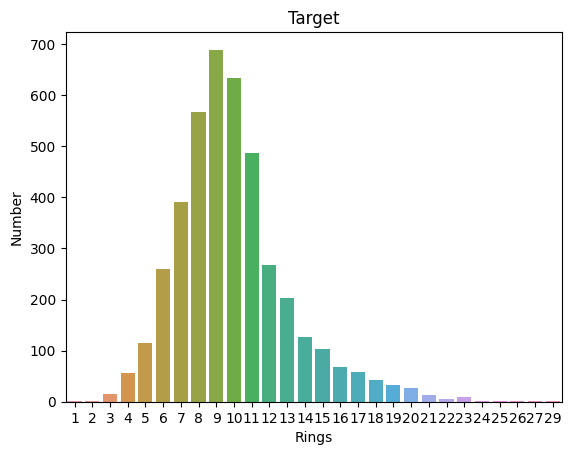

In [8]:
# seaborn countplot을 통한 각 레이블 도수 확인

sns.countplot (data=df, x='Rings')
plt.xlabel ("Rings")
plt.ylabel ("Number")
plt.title ("Target")
plt.show()

In [9]:
# target의 class 도수를 확인 (숫자로)

df['Rings'].value_counts()

Rings
9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64

In [10]:
# Sex 특성 제거 및 Rings의 재구성

print (df.columns)
df = df.drop(columns=['Sex']) # Sex 특성 제거

for ix in df.index :
    row = df.loc[ix]
    if row.Rings <= 8 :
        df.loc[ix, 'Rings'] = 0 # 'young'
    elif row.Rings >= 11 :
        df.loc[ix, 'Rings'] = 2 # 'old'
    elif row.Rings >=9 and row.Rings <= 10 :
        df.loc[ix, 'Rings'] = 1 # 'medium'
        
df.head()

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0


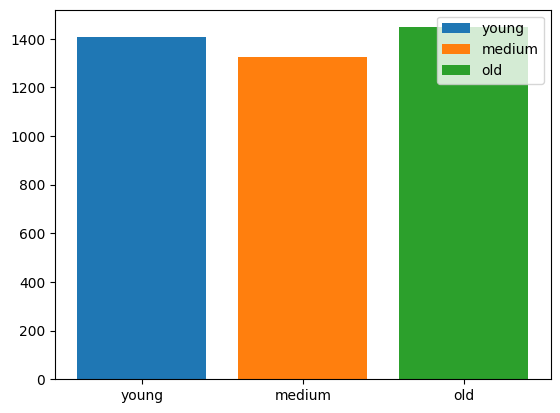

In [11]:
# 각 클래스별 갯수를 시각화

unique, counts = np.unique(df['Rings'].to_numpy(), return_counts=True)
class_counts = dict(zip(unique, counts))

plt.bar("young", class_counts[0], label="young")
plt.bar("medium", class_counts[1], label="medium")
plt.bar("old", class_counts[2], label="old")
plt.legend()
plt.show()

In [12]:
# 결측치 확인

df.isnull().sum()

Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [13]:
# 결측치 제거

df = df.dropna()
df.isnull().sum()

Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


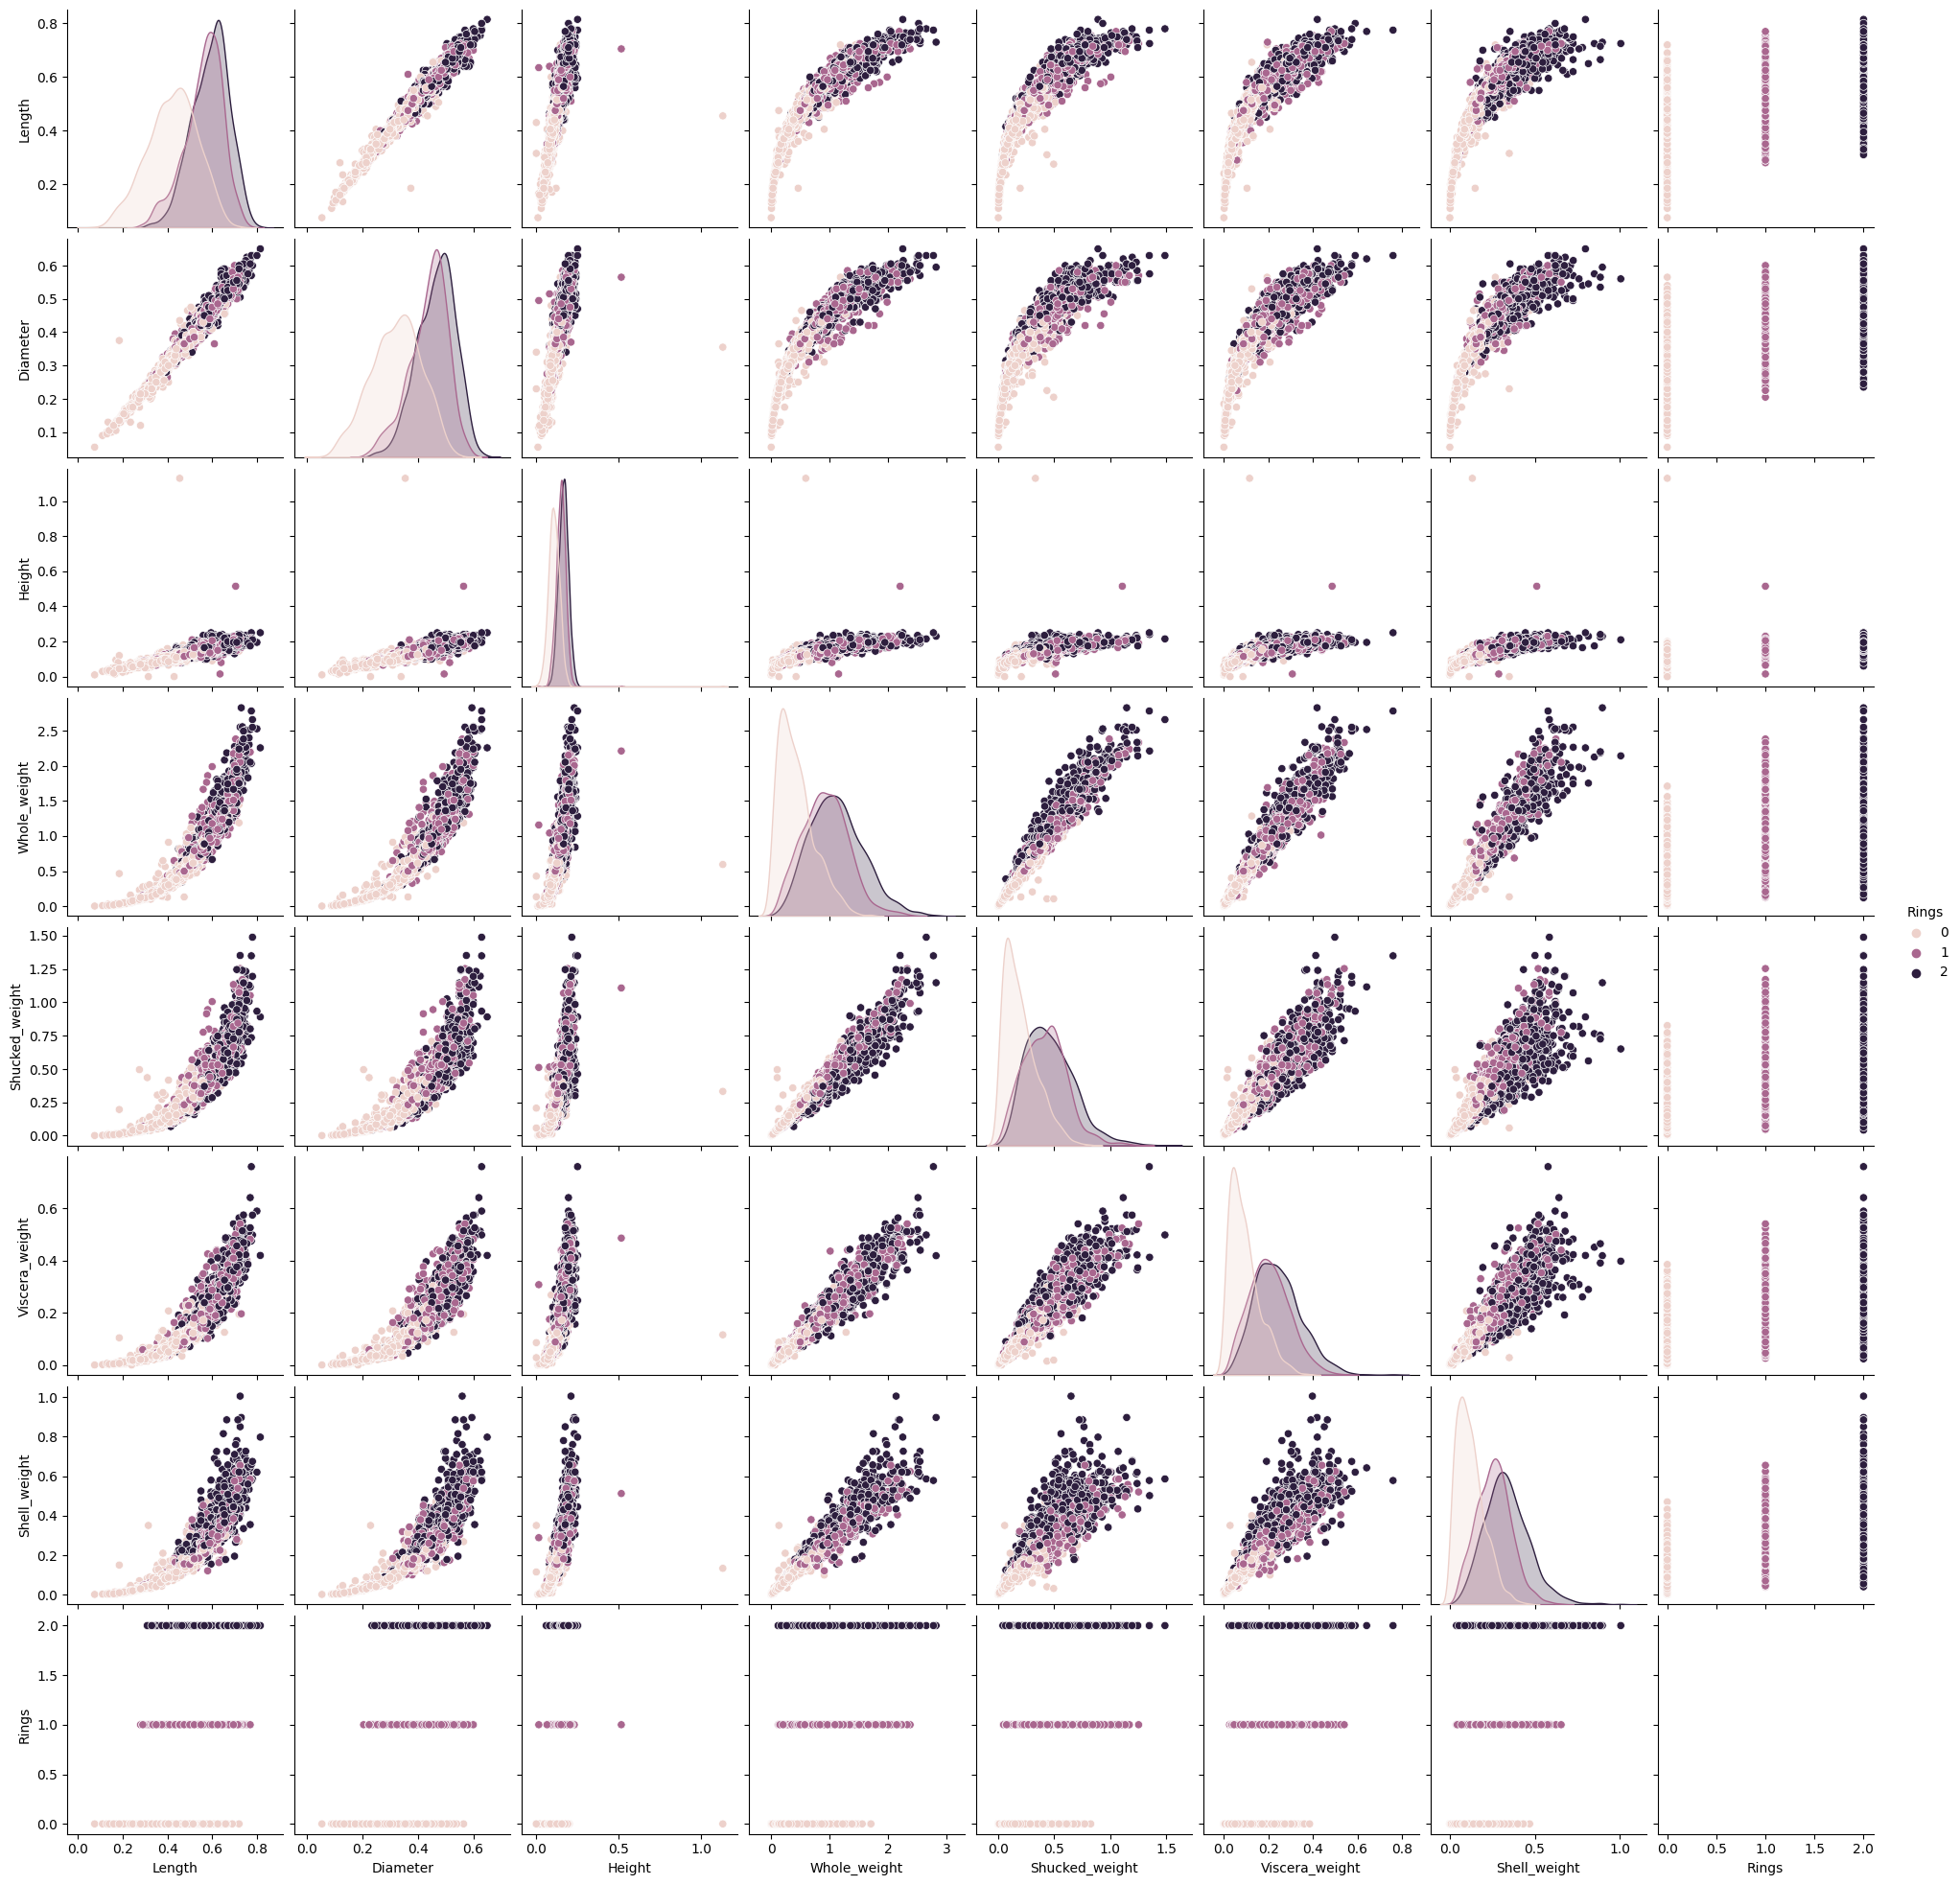

In [14]:
# pairplot를 사용해 각 feature의 상관관계 알아보기

import warnings 
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

sns.pairplot(df, vars=('Length', 'Diameter', 'Height', 
                       'Whole_weight', 'Shucked_weight', 'Viscera_weight', 
                       'Shell_weight', 'Rings',), hue ='Rings')
plt.show()

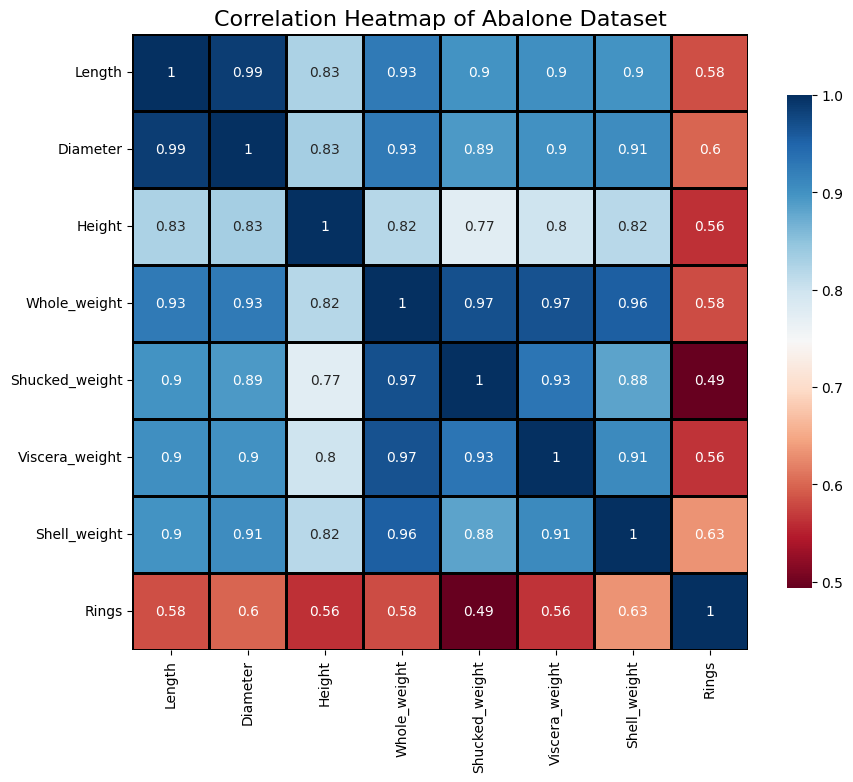

In [15]:
# seaborn을 통하여 heatmap 시각화

correlation_matrix = df[['Length', 'Diameter', 'Height', 
                         'Whole_weight', 'Shucked_weight', 
                         'Viscera_weight', 'Shell_weight', 'Rings']].corr() # feature (target 제외)
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Abalone Dataset', fontsize=16)
plt.show()

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_29407/3231520240.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist (ax = ax)


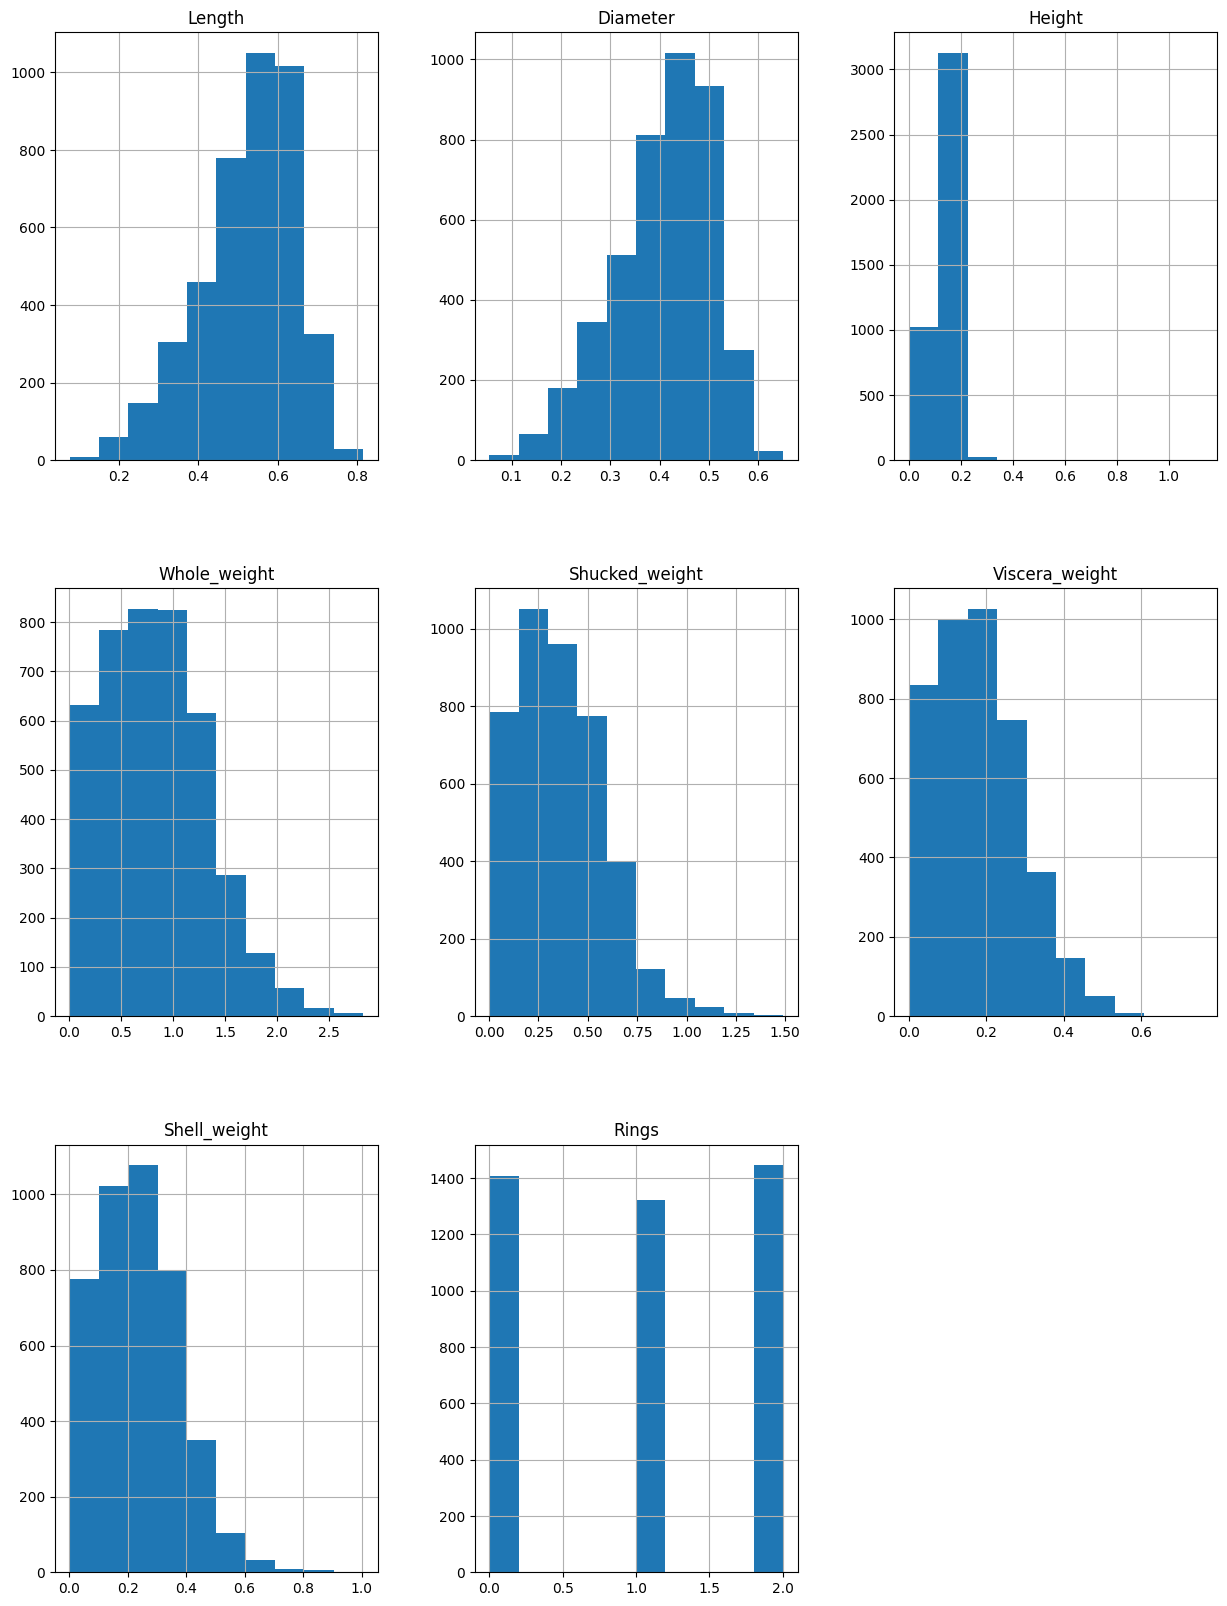

In [16]:
# 각 컬럼별 히스토 그램 확인

fig = plt.figure(figsize = (15, 20))
ax = fig.gca()
df.hist (ax = ax)
plt.show()

In [17]:
# abalone_input, abalone_target 만들기

abalone_input = df.drop('Rings', axis=1)
abalone_target = df['Rings']

print(abalone_target.value_counts())
abalone_input.head()

Rings
2    1447
0    1407
1    1323
Name: count, dtype: int64


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [18]:
# data split 및 normalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

raisin_input = df[df.columns[:-1]]
raisin_target = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(abalone_input, abalone_target, 
                                                   stratify=abalone_target, test_size=0.2)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [19]:
# train set에서 validation set을 하나 더 구성

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train,
                                                               test_size=0.2, 
                                                               stratify=y_train)

print (X_train_scaled.shape, X_val_scaled.shape)

(2672, 7) (669, 7)


In [21]:
# Dataset 구축 -> Dataloader 구축

batch_size = 32

from torch.utils.data import Dataset, DataLoader

class AbaloneDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

train_DL = DataLoader(AbaloneDataset(X_train_scaled, y_train), 
                     batch_size=batch_size, 
                     shuffle=True)

test_DL = DataLoader(AbaloneDataset(X_test_scaled, y_test), 
                     batch_size=batch_size, 
                     shuffle=False)

val_DL = DataLoader(AbaloneDataset(X_val_scaled, y_val), 
                     batch_size=batch_size, 
                     shuffle=False)

------

### 2. DNN (FCNN)
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 1000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 100으로 고정
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가한다.**

In [40]:
# modeling (다중 분류)

class FCNN (nn.Module) : 
    def __init__ (self) : 
        super().__init__()
        
        self.FCNN = nn.Sequential(
            nn.Linear(7, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2), 
            
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2), 
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2), 
            
            nn.Linear (64, 3)
        )
        
    def forward(self,x) :
        x = self.FCNN(x) 
        return x
    
device = 'cpu'
model = FCNN().to(device)
summary(model, 
       input_size=(32, 7))

Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [32, 3]                   --
├─Sequential: 1-1                        [32, 3]                   --
│    └─Linear: 2-1                       [32, 16]                  128
│    └─BatchNorm1d: 2-2                  [32, 16]                  32
│    └─ReLU: 2-3                         [32, 16]                  --
│    └─Dropout: 2-4                      [32, 16]                  --
│    └─Linear: 2-5                       [32, 32]                  544
│    └─BatchNorm1d: 2-6                  [32, 32]                  64
│    └─ReLU: 2-7                         [32, 32]                  --
│    └─Dropout: 2-8                      [32, 32]                  --
│    └─Linear: 2-9                       [32, 64]                  2,112
│    └─BatchNorm1d: 2-10                 [32, 64]                  128
│    └─ReLU: 2-11                        [32, 64]                  --
│    └─Dr

In [41]:
# compile

criterion = nn.CrossEntropyLoss()
epoch = 100
optimizer = optim.AdamW(model.parameters(), 
                      lr=0.001)

In [42]:
# training

loss_history = []
acc_history = []

model.train()
for ep in range(epoch):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    
    for X_batch, y_batch in train_DL:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        
        # inference
        y_hat = model.forward(X_batch)
        
        # loss
        loss = criterion(y_hat, y_batch)
        
        # deriviate
        optimizer.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        
        # train acc, loss 
        outputs = model.forward(X_batch)
        _, preds = torch.max(outputs, 1)
        train_acc += (preds == y_batch).float().mean().item()
        train_loss += loss.item()
        
        
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_DL:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()
            
            # train acc, loss 
            outputs = model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            _, preds = torch.max(outputs, 1)
            val_acc += (preds == y_batch).float().mean().item()
            val_loss += loss.item()
        
    train_acc /= len(train_DL)
    train_loss /= len(train_DL)
    val_acc /= len(val_DL)
    val_loss /= len(val_DL)
    
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))
    
    print(f"epoch {ep+1} : tr_acc {train_acc:.2f}, tr_loss {train_loss:.2f}, v_acc {val_acc:.2f}, v_loss {val_loss:.2f}")

epoch 1 : tr_acc 0.54, tr_loss 0.93, v_acc 0.63, v_loss 0.84
epoch 2 : tr_acc 0.63, tr_loss 0.80, v_acc 0.65, v_loss 0.81
epoch 3 : tr_acc 0.64, tr_loss 0.77, v_acc 0.66, v_loss 0.78
epoch 4 : tr_acc 0.65, tr_loss 0.75, v_acc 0.66, v_loss 0.77
epoch 5 : tr_acc 0.65, tr_loss 0.74, v_acc 0.65, v_loss 0.79
epoch 6 : tr_acc 0.65, tr_loss 0.74, v_acc 0.65, v_loss 0.76
epoch 7 : tr_acc 0.65, tr_loss 0.73, v_acc 0.67, v_loss 0.77
epoch 8 : tr_acc 0.67, tr_loss 0.73, v_acc 0.67, v_loss 0.77
epoch 9 : tr_acc 0.66, tr_loss 0.73, v_acc 0.67, v_loss 0.76
epoch 10 : tr_acc 0.67, tr_loss 0.73, v_acc 0.67, v_loss 0.77
epoch 11 : tr_acc 0.66, tr_loss 0.72, v_acc 0.67, v_loss 0.77
epoch 12 : tr_acc 0.66, tr_loss 0.72, v_acc 0.66, v_loss 0.77
epoch 13 : tr_acc 0.67, tr_loss 0.71, v_acc 0.67, v_loss 0.78
epoch 14 : tr_acc 0.67, tr_loss 0.72, v_acc 0.67, v_loss 0.76
epoch 15 : tr_acc 0.67, tr_loss 0.71, v_acc 0.67, v_loss 0.80
epoch 16 : tr_acc 0.67, tr_loss 0.71, v_acc 0.67, v_loss 0.77
epoch 17 : tr_acc

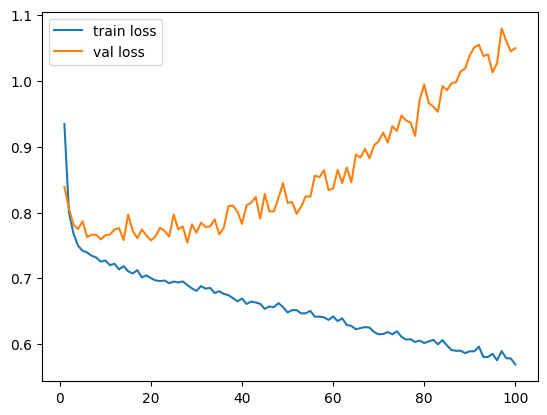

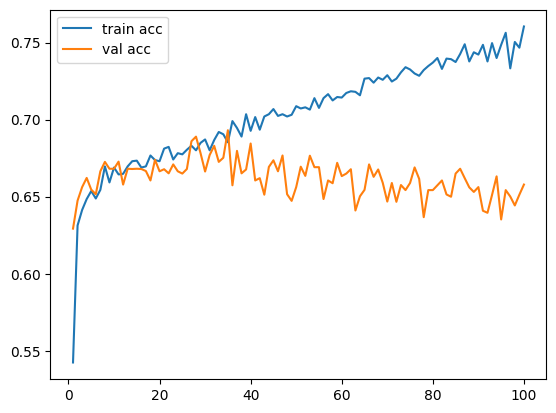

In [43]:
# loss, acc 시각화

plt.plot([ep for ep in range (1, epoch+1)], 
        [component[0] for component in loss_history],
        label='train loss')
plt.plot([ep for ep in range (1, epoch+1)], 
        [component[1] for component in loss_history],
        label='val loss')
plt.legend()
plt.show()

plt.plot([ep for ep in range (1, epoch+1)], 
        [component[0] for component in acc_history],
        label='train acc')
plt.plot([ep for ep in range (1, epoch+1)], 
        [component[1] for component in acc_history],
        label='val acc')
plt.legend()
plt.show()

In [44]:
# classifiacation report and confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_DL:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model.forward(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

print(confusion_matrix(all_targets, all_preds))
print(classification_report(all_targets, all_preds))

[[217  45  19]
 [ 65 122  78]
 [ 15  64 211]]
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       281
           1       0.53      0.46      0.49       265
           2       0.69      0.73      0.71       290

    accuracy                           0.66       836
   macro avg       0.65      0.65      0.65       836
weighted avg       0.65      0.66      0.65       836



-------

### 3. TabNet 
- Tabular 데이터는 아직 ML기법이 더 좋은 성능을 보일 때가 많으나, DL에서 TabNet은 Tabular 데이터에 매우 적합한 structure이다.
- TabNet은 기본적으로 트리 기반 모델인 Decision Tree와 유사한 구조를 가지고 있지만, Decision Tree와는 달리 그래디언트 부스팅 대신에 어텐션 메커니즘을 사용하게 된다

In [46]:
# modelling TabNet

import torch
import torch.nn as nn
import torch.nn.functional as F

class TabNet(nn.Module):
    def __init__(self):
        super(TabNet, self).__init__()
        
        self.n_steps = 3
        self.input_dim = 7
        
        # Attention layers for each step (feature selection)
        self.attention_layers = nn.ModuleList([
            nn.Linear(7, 7) for _ in range(10)
        ])
        
        # Feature processing layers for each step  
        self.feature_layers = nn.ModuleList([
            nn.Linear(7, 16) for _ in range(10)
        ])
        
        # Final classifier
        self.classifier = nn.Linear(16, 3)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Prior scales (어떤 feature가 이미 사용되었는지 추적)
        prior_scales = torch.ones_like(x)
        
        # Aggregated features across all steps
        aggregated = torch.zeros(batch_size, 16).to(x.device)
        
        for step in range(3):
            # Attention weights (어떤 feature를 볼지 결정)
            attention = torch.sigmoid(self.attention_layers[step](x))
            
            # Prior scales 적용 (이미 많이 사용된 feature는 덜 사용)
            attention = attention * prior_scales
            
            # Attention 정규화
            attention = F.softmax(attention, dim=1)
            
            # Feature selection 적용
            selected_features = x * attention
            
            # Feature processing
            step_output = F.relu(self.feature_layers[step](selected_features))
            
            # Aggregate
            aggregated += step_output
            
            # Prior scales 업데이트 (사용된 feature는 다음 step에서 덜 사용되도록)
            prior_scales = prior_scales * (1.5 - attention)
        
        # Final classification
        output = self.classifier(aggregated)
        
        return output

model = TabNet().to(device)
summary(model, 
       input_size=(32, 7))

Layer (type:depth-idx)                   Output Shape              Param #
TabNet                                   [32, 3]                   1,288
├─ModuleList: 1-5                        --                        (recursive)
│    └─Linear: 2-1                       [32, 7]                   56
├─ModuleList: 1-6                        --                        (recursive)
│    └─Linear: 2-2                       [32, 16]                  128
├─ModuleList: 1-5                        --                        (recursive)
│    └─Linear: 2-3                       [32, 7]                   56
├─ModuleList: 1-6                        --                        (recursive)
│    └─Linear: 2-4                       [32, 16]                  128
├─ModuleList: 1-5                        --                        (recursive)
│    └─Linear: 2-5                       [32, 7]                   56
├─ModuleList: 1-6                        --                        (recursive)
│    └─Linear: 2-6        

In [47]:
# compile

criterion = nn.CrossEntropyLoss()
epoch = 100
optimizer = optim.AdamW(model.parameters(), 
                      lr=0.001)

In [48]:
# training

loss_history = []
acc_history = []

model.train()
for ep in range(epoch):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    
    for X_batch, y_batch in train_DL:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        
        # inference
        y_hat = model.forward(X_batch)
        
        # loss
        loss = criterion(y_hat, y_batch)
        
        # deriviate
        optimizer.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        
        # train acc, loss 
        outputs = model.forward(X_batch)
        _, preds = torch.max(outputs, 1)
        train_acc += (preds == y_batch).float().mean().item()
        train_loss += loss.item()
        
        
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_DL:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()
            
            # train acc, loss 
            outputs = model.forward(X_batch)
            loss = criterion(outputs, y_batch)
            _, preds = torch.max(outputs, 1)
            val_acc += (preds == y_batch).float().mean().item()
            val_loss += loss.item()
        
    train_acc /= len(train_DL)
    train_loss /= len(train_DL)
    val_acc /= len(val_DL)
    val_loss /= len(val_DL)
    
    loss_history.append((train_loss, val_loss))
    acc_history.append((train_acc, val_acc))
    
    print(f"epoch {ep+1} : tr_acc {train_acc:.2f}, tr_loss {train_loss:.2f}, v_acc {val_acc:.2f}, v_loss {val_loss:.2f}")

epoch 1 : tr_acc 0.50, tr_loss 1.05, v_acc 0.57, v_loss 0.97
epoch 2 : tr_acc 0.56, tr_loss 0.93, v_acc 0.55, v_loss 0.87
epoch 3 : tr_acc 0.56, tr_loss 0.87, v_acc 0.57, v_loss 0.84
epoch 4 : tr_acc 0.56, tr_loss 0.85, v_acc 0.57, v_loss 0.83
epoch 5 : tr_acc 0.57, tr_loss 0.85, v_acc 0.58, v_loss 0.83
epoch 6 : tr_acc 0.57, tr_loss 0.84, v_acc 0.59, v_loss 0.83
epoch 7 : tr_acc 0.58, tr_loss 0.84, v_acc 0.60, v_loss 0.83
epoch 8 : tr_acc 0.59, tr_loss 0.83, v_acc 0.59, v_loss 0.83
epoch 9 : tr_acc 0.58, tr_loss 0.83, v_acc 0.60, v_loss 0.82
epoch 10 : tr_acc 0.60, tr_loss 0.83, v_acc 0.60, v_loss 0.82
epoch 11 : tr_acc 0.60, tr_loss 0.82, v_acc 0.61, v_loss 0.82
epoch 12 : tr_acc 0.60, tr_loss 0.82, v_acc 0.61, v_loss 0.82
epoch 13 : tr_acc 0.60, tr_loss 0.81, v_acc 0.61, v_loss 0.82
epoch 14 : tr_acc 0.61, tr_loss 0.81, v_acc 0.63, v_loss 0.81
epoch 15 : tr_acc 0.62, tr_loss 0.80, v_acc 0.63, v_loss 0.81
epoch 16 : tr_acc 0.62, tr_loss 0.80, v_acc 0.63, v_loss 0.81
epoch 17 : tr_acc

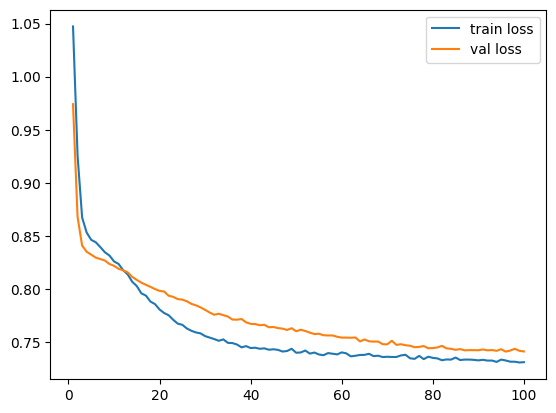

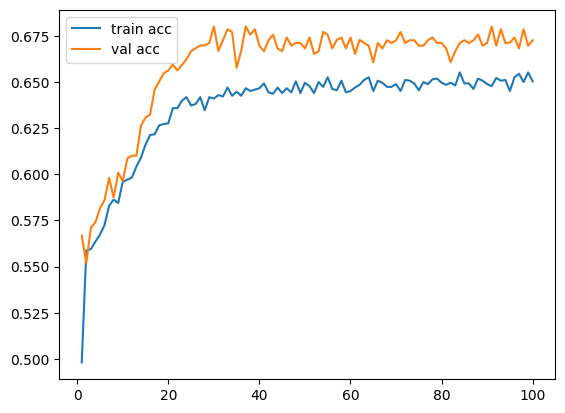

In [49]:
# loss, acc 시각화

plt.plot([ep for ep in range (1, epoch+1)], 
        [component[0] for component in loss_history],
        label='train loss')
plt.plot([ep for ep in range (1, epoch+1)], 
        [component[1] for component in loss_history],
        label='val loss')
plt.legend()
plt.show()

plt.plot([ep for ep in range (1, epoch+1)], 
        [component[0] for component in acc_history],
        label='train acc')
plt.plot([ep for ep in range (1, epoch+1)], 
        [component[1] for component in acc_history],
        label='val acc')
plt.legend()
plt.show()

In [50]:
# classifiacation report and confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_DL:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model.forward(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

print(confusion_matrix(all_targets, all_preds))
print(classification_report(all_targets, all_preds))

[[232  42   7]
 [ 74 128  63]
 [ 18  77 195]]
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       281
           1       0.52      0.48      0.50       265
           2       0.74      0.67      0.70       290

    accuracy                           0.66       836
   macro avg       0.66      0.66      0.66       836
weighted avg       0.66      0.66      0.66       836

